# 第三章 `k`近邻模型

## 模型简述
**$L_p$距离**
$$L_p=(\sum_{l=1}^n{|x_i^l - x_j^l|^p})^\frac{1}{p}$$
k值小，容易过拟合；k值大，模型变得简单。

**近似误差**：模型过于简单，无法完全捕捉数据中的复杂模式和规律，即计算的模型向真模型近似的误差<br>
**估计误差**：模型在没见过的数据上的预测性能的误差，衡量泛化能力

In [49]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
%config InlineBackend.figure_format ='svg'

## 数学方法实现
### 课本例3.1

In [1]:
x1 = [1, 1]
x2 = [5, 1]
x3 = [4, 4]


def L(x, y, p=2):
    if len(x) == len(y) and len(x) > 1:
        sum = 0
        for i in range(len(x)):
            sum += np.power(abs(x[i]-y[i]), p)
        return np.power(sum, 1/p)
    else:
        return 0

In [14]:
for i in range(1, 6):
    r = {'x1-{}'.format(x): L(x1, x, p=i) for x in [x2, x3]}
    print(f'p={i}时, ', min(zip(r.values(), r.keys())))

p=1时,  (4.0, 'x1-[5, 1]')
p=2时,  (4.0, 'x1-[5, 1]')
p=3时,  (3.7797631496846193, 'x1-[4, 4]')
p=4时,  (3.5676213450081633, 'x1-[4, 4]')
p=5时,  (3.446095064991105, 'x1-[4, 4]')


### 鸢尾花数据集

In [18]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
df.head()

,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


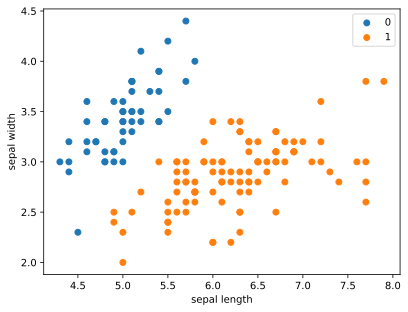

In [28]:
plt.scatter(df.iloc[:50, 0], df.iloc[:50, 1], label='0')
plt.scatter(df.iloc[50:, 0], df.iloc[50:, 1], label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [30]:
data = np.array(df.iloc[:100, [0, 1, -1]])
X, y = data[:, [0, 1]], data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 数学实现knn思路
1. **找到`x_train`中距离`x_test`最近的`n`个点**
    1. 依次计算`x_test`与`x_train`中前`n`个点的距离
    2. 找到前`n`个点的距离中最大的值`dist_n_max`
    3. 计算`x_test`与第`n+1`个点的距离`dist`
    4. 如果`dist`小于`dist_n_max`，就把`dist_n_max`替换为`dist`
    5. 循环B~D
<br>最终剩下离`x_train`最短的`n`个点
2. **统计最近的`n`个中的最多的类型并返回**

In [65]:
class model_knn():
    def __init__(self, X_train, y_train, n_neighbors=3, p=3):
        self.X_train = X_train
        self.y_train = y_train
        self.n = n_neighbors
        self.p = p
    
    def predict(self, X):
        knn_list = []
        for i in range(self.n):
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p)
            knn_list.append((dist, self.y_train[i]))
            
        for i in range(self.n, len(X_train)):
            max_index = knn_list.index(max(knn_list, key=lambda x: x[0]))
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p)
            if knn_list[max_index][0] > dist:
                knn_list[max_index] = (dist, self.y_train[i])
        
        # 统计
        knn = [k[-1] for k in knn_list]
        count_pairs = Counter(knn)  # 字典迭代对象，值：出现的次数
        max_count = sorted(count_pairs.items(), key=lambda x: x[1])[-1][0]
        # count_pairs.items():返回字典键值对组成的元组列表
        # sorted()：对可迭代对象进行排序，默认为升序，reverse=True时，为降序
        # key=lambda x: x[1]：按照元组的第二个元素进行排序
        # 最后返回排序后元组第二个元素最大的元组的第一个元素
        
        return max_count
        
    def score(self, X_test, y_test):
        right_count = 0
        for X, y in zip(X_test, y_test):
            label = self.predict(X)
            if y == label:
                right_count +=1
        return right_count/len(X_test)

In [71]:
clf = model_knn(X_train, y_train)
clf.score(X_test, y_test)

1.0

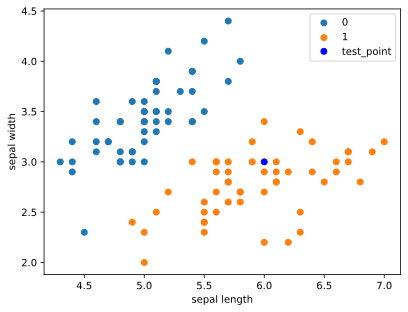

In [73]:
test_point = [6.0, 3.0]
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.plot(test_point[0], test_point[1], 'bo', label='test_point')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

### kd树

In [87]:
2%2 +1

1

## `sklearn-knn`实现

### `KNeighborsClassifier`模型参数
在sklearn中，KNN（K-Nearest Neighbors）是一种简单且常用的机器学习算法，用于分类和回归问题。下面是KNN算法在sklearn中的所有参数以及它们的具体用法：

参数：
- n_neighbors: 这是KNN算法中的一个重要参数，表示选择多少个最近邻居来进行投票或计算回归值。默认值为5。
- weights: 这是用于预测时的权重函数。有三个可选值：
    - 'uniform': 所有邻居权重相等，即简单地进行投票或平均。
    - 'distance': 权重是距离的倒数，越近的邻居权重越大。
    - 自定义函数: 您可以传递一个函数来定义自己的权重逻辑。
- algorithm: 用于计算最近邻居的算法。有四个可选值：
    - 'auto': 自动选择最适合数据的算法。对于大数据集，使用'kd_tree'或'ball_tree'，小数据集使用'brute'。
    - 'ball_tree': 使用BallTree算法。
    - 'kd_tree': 使用KDTree算法。
    - 'brute': 使用蛮力搜索方式，适用于较小的数据集。
    - leaf_size: 使用'ball_tree'或'kd_tree'算法时，叶子节点的大小。默认是30。
- p: 用于计算距离的参数。有两个常用的值：
    - p=1: 使用曼哈顿距离（L1距离）。
    - p=2: 使用欧式距离（L2距离）。
- metric: 用于计算距离的度量标准。默认是'minkowski'，对应于Lp距离，其中p由p参数确定。
- metric_params: 传递给度量函数的额外参数。
- n_jobs: 并行运行的作业数量（仅在scikit-learn版本为0.22以上时可用）

### 鸢尾花数据集

In [2]:
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
knn_classifier = knn(n_neighbors=5, algorithm="kd_tree")
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("准确率：", accuracy)

准确率： 1.0


### Titanic数据集

In [63]:
data = pd.read_csv(r'F:\DataSets\Tatinic\train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
# Preprocessing
data = data.drop(['Name', 'Ticket', 'Cabin', 'Embarked', 'PassengerId'], axis=1)
data['Sex'] = data['Sex'].map({'female': 0, 'male': 1}).astype(int)
data = data.fillna(0)

# Set up features and target
X = data.drop('Survived', axis=1)
y = data['Survived']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## 数据标准化
$$x_{new} = \frac{x - \mu}{\sigma}$$
其中：
- $x$是原始特征值
- $\mu$是特征的均值
- $\sigma$是特征的标准差<br>
标准化后的特征$x_{new}$具有零均值和单位方差，即标准差为1。这种预处理方式可以使得不同特征具有相同的尺度，有利于一些基于距离的算法（如KNN和SVM）的表现。

### 测试集的标准化
- <font color=red>**测试集必须用训练集拟合的参数进行标准化**</font>，不能用测试集自己的数据计算参数，因为在实际情况下，我们不了解测试集的数据分布
- 比如模型训练好后，现在只有一个待预测的(X, y)，是没法知道它的标准化参数的
- 使用训练集对测试集进行transform，可以是测试集和训练集保持相同的分布，这样模型评估的结果会跟准确
- 如果用测试集自己的数据拟合标准化参数, 并用来tranform训练集，很容易导致数据泄露,使模型对测试集产生过拟合

In [62]:
test_data = np.array([[1.0, 200.0],
                      [3.0, 400.0],
                      [5.0, 600.0]])

# 创建StandardScaler的实例
scaler = StandardScaler()

# 将数据拟合到标准化器上
scaler.fit(test_data)

# 对数据进行转换（应用标准化）
scaled_data = scaler.transform(test_data)

print(scaled_data)
print("原始数据每列均值", np.mean(test_data, axis=0))
print("原始数据每列标准差", np.std(test_data, axis=0))
print("标准化后每列均值", np.mean(scaled_data, axis=0))
print("标准化后每列均值", np.std(scaled_data, axis=0))

[[-1.22474487 -1.22474487]
 [ 0.          0.        ]
 [ 1.22474487  1.22474487]]
原始数据每列均值 [  3. 400.]
原始数据每列标准差 [  1.63299316 163.29931619]
标准化后每列均值 [0. 0.]
标准化后每列均值 [1. 1.]


<font color='blue'>**用训练集的标准化参数`transform`测试集**</font>

In [ ]:
# Feature scaling
# 只对X进行scaling，包含测试集和训练集
scaler = StandardScaler()
scaler.fit(X_train)  # 计算X_train中每个特征的mean和std

X_train = scaler.transform(X_train)  # 用 X_train中每个特征的mean和std标准化 X_train
X_test = scaler.transform(X_test)  # 用 X_train中每个特征的mean和std标准化 X_test

In [60]:
# Training
model = knn(n_neighbors=3, algorithm="auto")
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[93 13]
 [23 50]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       106
           1       0.79      0.68      0.74        73

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [35]:
np.mean(test_data, axis=0)

array([  3., 400.])

In [25]:
np.std(data)

229.64519735162472

In [26]:
np.mean(scaled_data)

0.0

In [27]:
np.std(scaled_data)

0.9999999999999999

In [29]:
data[:,0]

TypeError: list indices must be integers or slices, not tuple

In [30]:
np.array(data)

array([[  1., 200.],
       [  3., 400.],
       [  5., 600.]])